In [1]:
from modeling import *
from som import SOM
from sklearn.preprocessing import MinMaxScaler

In [12]:
df = read_csv('features-BIDU-5y.csv')
df = prepare_df(df)

# dropping columns for training
df_prepared = df.drop(columns=[' High', ' Low', 'profit', 'close_plus_20_days', 'Date'])
df_train_columns = df_prepared.columns

# scaling data
scaler = MinMaxScaler()
df_prepared = scaler.fit_transform(df_prepared)

#splitting dataset into training and testing
train_len = len(df_prepared)-365
df_train = df_prepared[:train_len]
df_test = df_prepared[train_len:]


Tak jak pisał w artykule, niektóre zmienne mogą być skorelowane i warto byłoby coś z tym zrobił. On tam proponował usunąć te skorelowane, ale ja po prostu robie pca dzięki czemu też pozbywam się korelacji

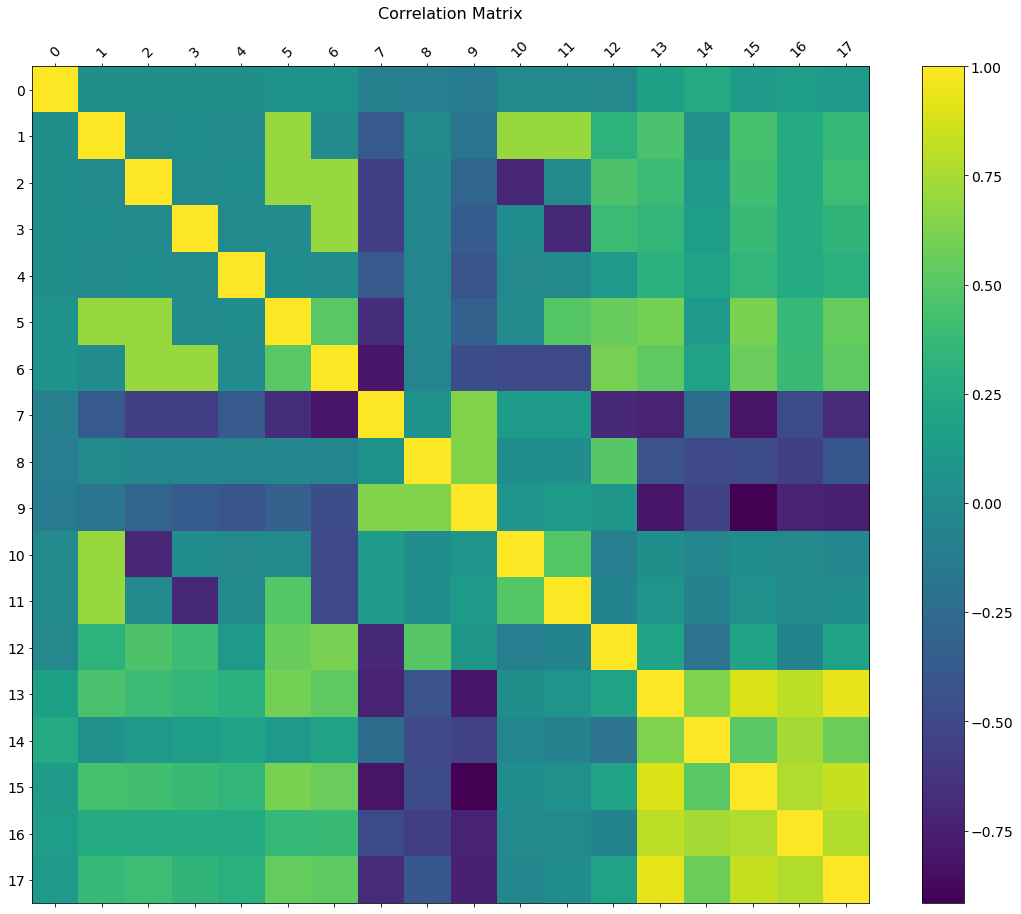

In [13]:
plot_corelation_matrix(df_prepared)

In [14]:
from sklearn.decomposition import PCA
# increasing amount of column to 90% of initial amount
pca = PCA(n_components=(int(df_prepared.shape[1]*0.9)))
df_prepared = principalComponents = pca.fit_transform(df_prepared)

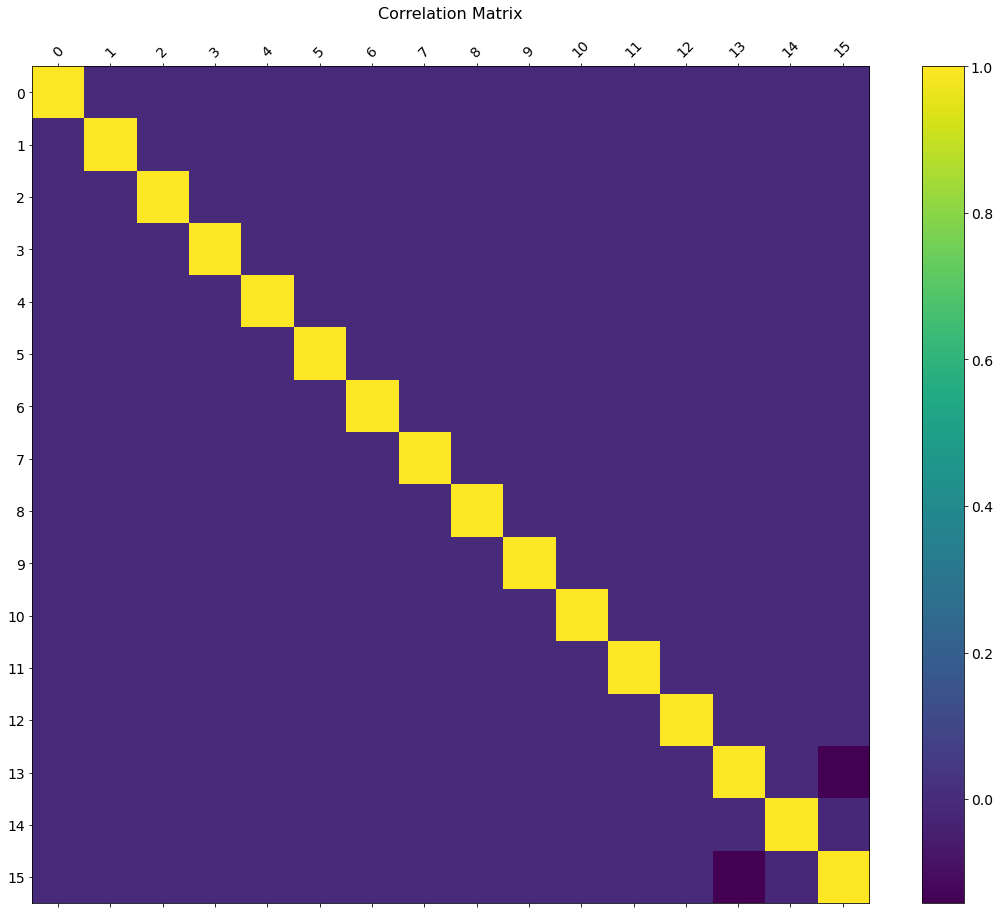

In [15]:
plot_corelation_matrix(df_prepared)

Error history plot done!


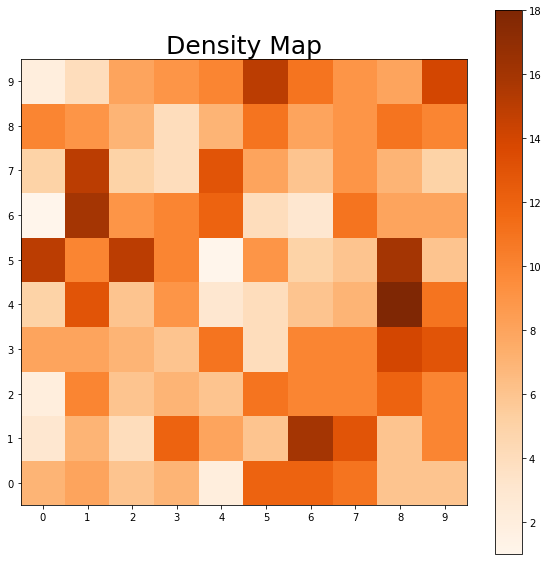

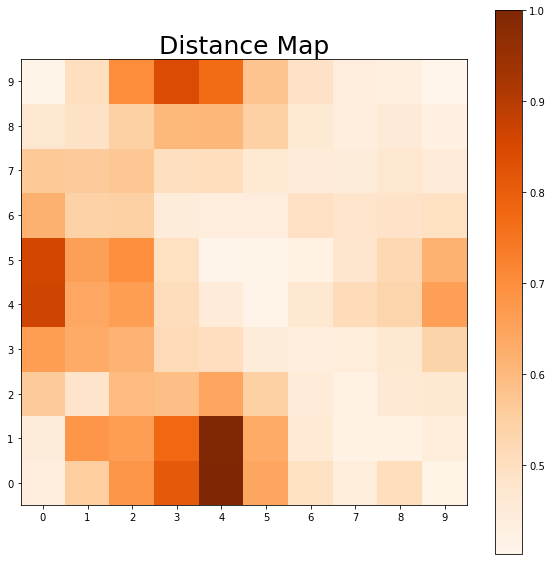

In [16]:
# fitting the model
som = SOM(10, 10)  
som.fit(df_train, 10000, save_e=True, interval=100)
som.plot_error_history(filename='../images/som_error.png')

# plotting density and distance map
som.plot_density_map(df_train)
som.plot_distance_map()

# converting numpy arrays to dataframes
df_train = pd.DataFrame(df_train, columns=df_train_columns)
df_test = pd.DataFrame(df_test, columns=df_train_columns)

# creating column with cluster basing on model prediction
df_train['cluster'] = df_train.apply(lambda x: som_predict(x, som), axis=1)
df_test['cluster'] = df_test.apply(lambda x: som_predict(x, som), axis=1)

# joining train and test dataframes with previously dropped columns, which will be useful in the further part of the script
final_df_train = df_train.join(df[['Date','Price','close_plus_20_days','profit']].iloc[:, :train_len], lsuffix='_org')
final_df_test = df_test.join(df[['Date','Price','close_plus_20_days','profit']].iloc[train_len:].reset_index(drop=True), lsuffix='_org')

# callculating mean profit per custer
profit_per_cluster = pd.DataFrame(final_df_train.groupby(by='cluster')['profit'].mean(), columns=['profit']).reset_index()

**Notatka**

*Myślę, że warto będzie jeśli przeczytasz sobie czym jest density i dsitance map w sieciach kohonena i jakoś skomentujesz to wynika z tych zdjęć.*

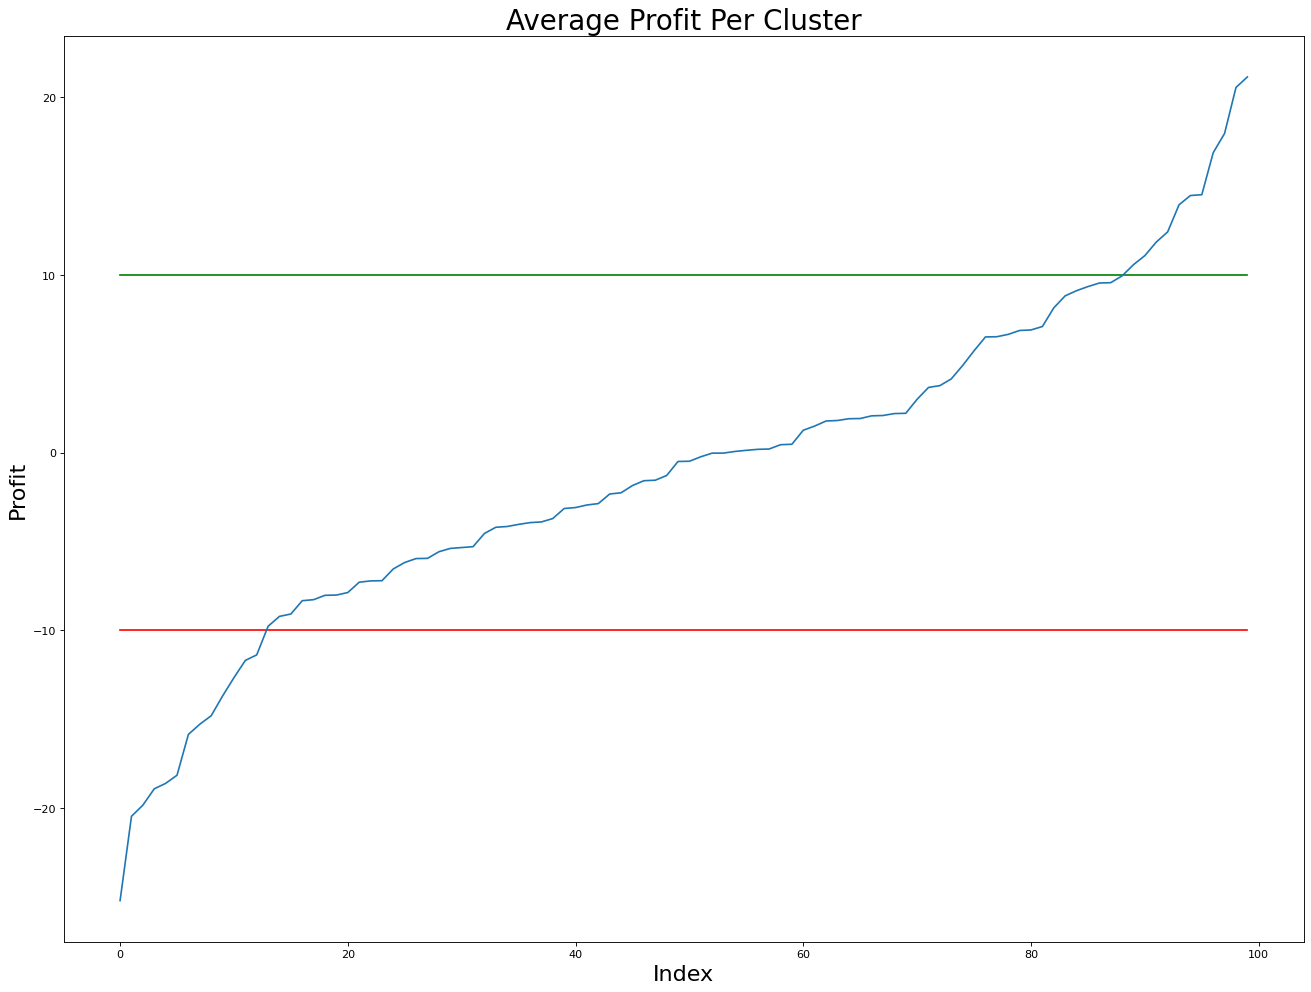

In [17]:
plot_avg_cluster_profit(final_df_train)

Basing on the average return of each cluster we are trying to find best cutoffs points, after which the cluster will be labeled as buy, sell and hold.

**Notatka**

*W przypadku bidu zdecydowałem się ustawić punkty odcięcia na -10 i 10. Dzięki temu sprzedajemy tylko w clustrach z średnim niskim profitem, trzymamy tam gdzie nie jest jakoś bardzo skrajny, a sprzedajemy tam gdzie jest duży. W przypadku, w którym dolny cutoff przesunęlibyśmy zbyt nisko, a górny zbyt wysoko, istnieje szansa, że po zaaplikowaniu predykcji na zbiorze testowym (czyli najnowszych danych) żadne próbki nie zostałyby oznaczone jako kup lub sprzedaj. Moglibyśmy też próbować postawić tylko jedną granicę (na 0) i wtedy to co powyżej to sprzedajemy, a to co poniżej to sprzedajemy, ale w praktyce, gdgbyśmy zaaplikowali coś takiego do danych testowych, najprawdopodobniej okazałoby się, że grupy te nie są od siebie dostatecznie różne i albo byśmy nie zarabiali albo tracili*

In [18]:
lower_cutoff = -10
higher_cutoff = 10

buy_cluster = list(profit_per_cluster.loc[profit_per_cluster['profit']>higher_cutoff]['cluster'])
sell_cluster = list(profit_per_cluster.loc[profit_per_cluster['profit']<lower_cutoff]['cluster'])
hold_cluster = list(profit_per_cluster.loc[(profit_per_cluster['profit']<=higher_cutoff) & (profit_per_cluster['profit']>=lower_cutoff)]['cluster'])

In [19]:
# callculating mean profit for each cluster on training and testing dataset
buy_clusters_train_mean_profit = final_df_train.loc[final_df_train['cluster'].isin(buy_cluster)]['profit'].mean()
print(f'buy_clusters_train_mean_profit: {buy_clusters_train_mean_profit}')
buy_clusters_test_mean_profit = final_df_test.loc[final_df_test['cluster'].isin(buy_cluster)]['profit'].mean()
print(f'buy_clusters_test_mean_profit: {buy_clusters_test_mean_profit}\n')

hold_clusters_train_mean_profit = final_df_train.loc[final_df_train['cluster'].isin(hold_cluster)]['profit'].mean()
print(f'hold_clusters_train_mean_profit: {hold_clusters_train_mean_profit}')
hold_clusters_test_mean_profit = final_df_test.loc[final_df_test['cluster'].isin(hold_cluster)]['profit'].mean()
print(f'hold_clusters_test_mean_profit: {hold_clusters_test_mean_profit}\n')

sell_clusters_train_mean_profit = final_df_train.loc[final_df_train['cluster'].isin(sell_cluster)]['profit'].mean()
print(f'sell_clusters_train_mean_profit: {sell_clusters_train_mean_profit}')
sell_clusters_test_mean_profit = final_df_test.loc[final_df_test['cluster'].isin(sell_cluster)]['profit'].mean()
print(f'sell_clusters_test_mean_profit: {sell_clusters_test_mean_profit}')

buy_clusters_train_mean_profit: 15.11621212121212
buy_clusters_test_mean_profit: -0.47641025641025603

hold_clusters_train_mean_profit: -0.3535233918128664
hold_clusters_test_mean_profit: 1.905

sell_clusters_train_mean_profit: -16.1740206185567
sell_clusters_test_mean_profit: -2.2730000000000006


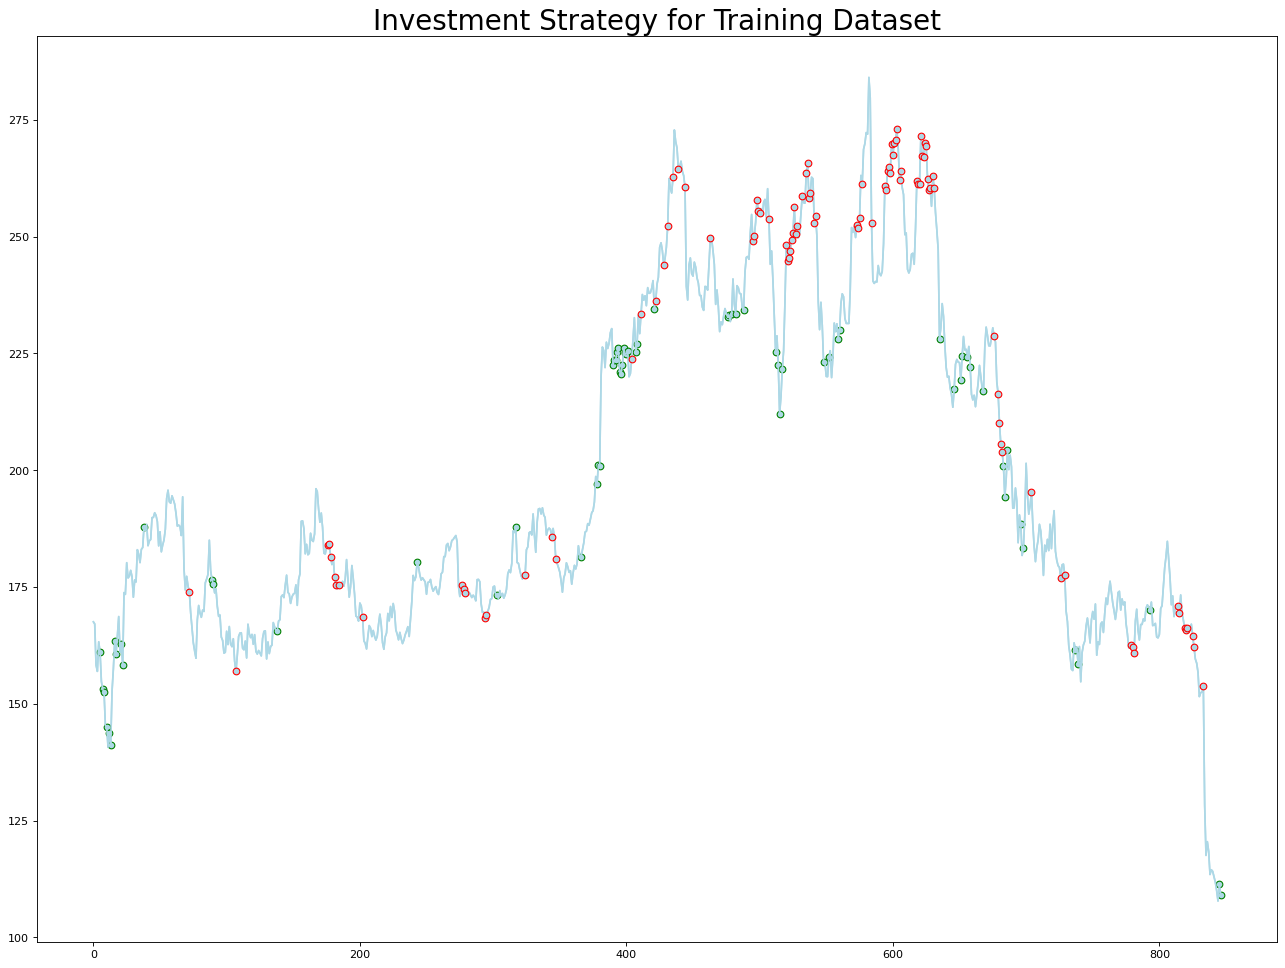

In [20]:
plot_strategy(final_df_train,'Training',buy_cluster, sell_cluster )

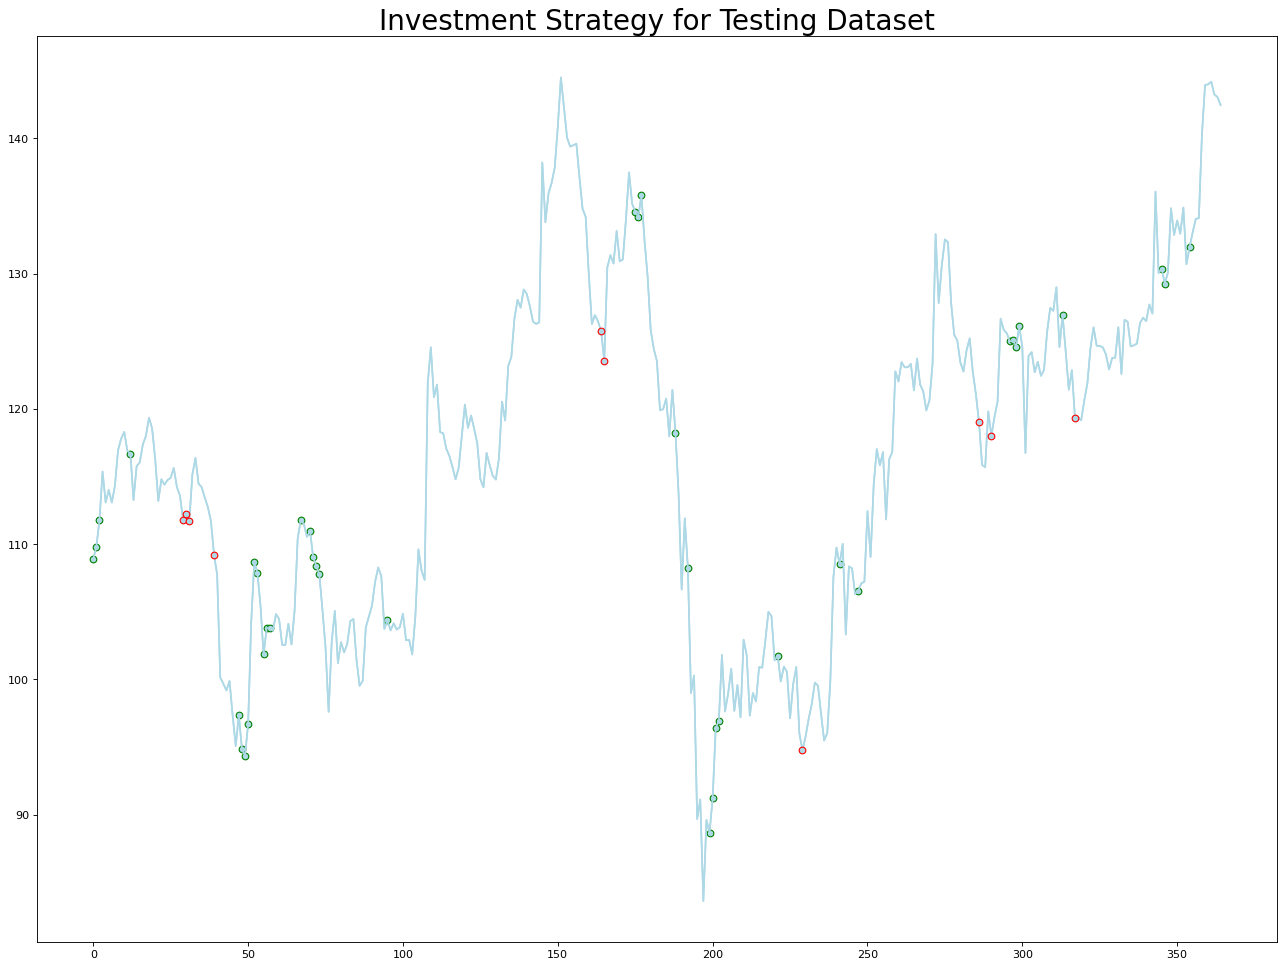

In [21]:
plot_strategy(final_df_test,'Testing',buy_cluster, sell_cluster )

**Notatka**

*profit to (wartość akcji w t+20) - (wartość akcji w t)*
*tak więc dla danych treningowych clustry są wyznaczone sensownie, ale to nic dziwnego, bo dzieliliśmy je w taki sposób, aby dla danych z etykieta sell profit był znacząco mniejszy od 0, dla danych z etykietą keep bliski 0, a dla danych z etykietą sell jak najwyższy*

*W przypadku danych testowych nie jest już tak kolorowo. Co prawda profit dla danych z etykietą sell jest cały czas mniejszy od 0, co nas cieszy (bo cena po 20 dniach jest niższa niż była zanim sprzedaliśmy), ale dla danych z etykietą buy profit też jest mniejszy od 0, co znaczy, że robimy to w złym momencie (bo kupujemy drożej niż sprzedajemy) *

*Mimo wszystko zakładając, że ilość transakcji sell jest więcej niż buy, bylibyśmy w stanie zarabiać na takiej taktyce*